In [1]:
# 기본 모듈
import matplotlib.pylab as plt
import ipywidgets as widgets
import pandas as pd
import numpy as np
import datetime
import requests
import time
import json
import os
import re
from ipywidgets import interact
from bs4 import BeautifulSoup
from tqdm import tqdm
from datetime import date

# 시각화 모듈
from IPython.display import Image as disImage
from PIL import Image, ImageFont, ImageDraw
from pandas.io.json import json_normalize
from IPython.display import clear_output
import seaborn as sns

# Py확장자 모듈
from get_information import get_history
from get_information import get_finance
from kosdak150 import get_kosdak150
from kospi200 import get_kospi200

## 크롤링 

In [2]:
class RED_Cr:

    # 크롤링 폴더 세부 경로
    path_cr = ['stock', 'etf', 'finance']

    def __init__(self, CR_PATH, years):
        self.CR_PATH = CR_PATH
        self.years = years
        self.kospidak = pd.read_csv("./data/list_stock.csv", encoding='cp949')

    # 1. 주식 크롤링
    def stock(self):
        kospi_df = get_kospi200()
        kosdak_df = get_kosdak150()
        kospi_df['분류'] = 'kospi200'
        kosdak_df['분류'] = 'kosdak150'
        kospidak = pd.concat([kospi_df, kosdak_df], ignore_index=True)
        self.kospidak = kospidak
        kospidak.to_csv(self.CR_PATH+'list_stock.csv',  encoding='cp949', index=False)


        path = self.CR_PATH+RED_Cr.path_cr[0]
        if not os.path.isdir(path):
            os.makedirs(path)

        # 각 종목별 과거 데이터 저장
        for itemcode, itemname in tqdm(zip(kospidak['종목코드'], kospidak['종목명'])):
            itemcode = str(itemcode).zfill(6)
            df = get_history(itemcode, self.years)  # n년치 가져오기: 모든 과거 데이터 크롤링
            file_name = os.path.join(path, '{}.csv'.format(itemname))
            df.to_csv(file_name, encoding='cp949')
            
        print('주식 데이터 크롤링이 완료되었습니다.')
    
        return

    # 2. ETF 크롤링
    def etf(self):
        etf_df = pd.read_csv(self.CR_PATH+'etf_list.csv', encoding='euc-kr')
        path = self.CR_PATH+RED_Cr.path_cr[1]

        if not os.path.isdir(path):
            os.makedirs(path)

        # 각 종목별 과거 데이터 저장
        for itemcode, itemname in tqdm(zip(etf_df['itemcode'], etf_df['itemname'])):
            itemcode = str(itemcode).zfill(6)
            df = get_history(itemcode, self.years)  # n년치 가져오기: 모든 과거 데이터 크롤링
            file_name = os.path.join(path, '{}.csv'.format(itemname))
            df.to_csv(file_name, encoding='cp949')
            
        print('ETF 데이터 크롤링이 완료되었습니다.')    
        return

    # 3. 재무정보 크롤링
    def finance(self):        
        path = self.CR_PATH+RED_Cr.path_cr[2]
        if not os.path.isdir(path):
            os.makedirs(path)

        ROE = []
        PER = []
        # 각 종목별 재무정보 저장 / 예상 컨센서스 데이터가 있어서, 빈 데이터 들이 많음....
        for itemcode, itemname in tqdm(zip(self.kospidak['종목코드'], self.kospidak['종목명'])):
            itemcode = str(itemcode).zfill(6)
            df = get_finance(itemcode)
            temp = df[['영업이익률','PER(배)']]
            temp['영업이익률'].replace('', np.nan, inplace=True)
            temp['PER(배)'].replace('', np.nan, inplace=True)
            temp = temp.dropna()
            
            ROE.append(list(temp['영업이익률'].values[-2:]))
            PER.append(list(temp['PER(배)'].values[-2:]))
            
            file_name = os.path.join(path, '{}.csv'.format(itemname))
            df.to_csv(file_name, encoding='cp949')
            
        self.kospidak['영업이익률'] = ROE
        self.kospidak['PER'] = PER
        self.kospidak.to_csv('./data/list_stock.csv', encoding='cp949')
        print('재무제표 데이터 크롤링이 완료되었습니다.')    
        return
    
    # 뉴스기사 분석 
    def

## 전처리 

In [3]:
class RED_preprocess : # 최소 150일 이상의 데이터에 대해 유효할듯 -> 나중에 전략 적용시 전제조건으로
    
      
    def process1 (x) :
        # 일수익률  
        x['일수익률'] = round(x['close price'].rolling(window=2).apply(lambda x: (x[1] - x[0])/ x[0]) * 100,2)
        
        # 이동평균선(5,20,60,120)   
        x['ma5'] = x['close price'].rolling(window=5).mean()
        x['ma5'] = x['ma5'].fillna(x['close price'])
        x['ma20'] = x['close price'].rolling(window=20).mean()
        x['ma20'] = x['ma20'].fillna(x['close price'])
        x['ma60'] = x['close price'].rolling(window=60).mean()
        x['ma60'] = x['ma60'].fillna(x['close price'])
        x['ma120'] = x['close price'].rolling(window=120).mean()
        x['ma120'] = x['ma120'].fillna(x['close price'])
        x[['ma5','ma20','ma60','ma120']] = x[['ma5','ma20','ma60','ma120']].astype(int)
            
        # volume oscillator
        short_ma = x['amount'].rolling(window=5).mean()
        long_ma = x['amount'].rolling(window=20).mean()
        x['volume oscillator'] = (short_ma - long_ma)/ short_ma * 100
        
        # william's %R
        maxx = x['close price'].rolling(window=14).max()
        minx = x['close price'].rolling(window=14).min()
        x['williams'] = ((maxx - x['close price'])/(maxx - minx)) * -100
        
        return x
    
    def process2(x):
        # 이격도(%) = (주가 / N일 이동평균지수)*100
        # 주가는 종가 기준, 이평선은 20일선과 60일선이 가장 많이 쓰임
        # 20일, 60일 이격도(%)
        x['disparity_20'] = x['close price']/x['ma20']*100
        x['disparity_60'] = x['close price']/x['ma60']*100

        # AB-Ratio
        # A-Ratio= 일정기간동안의 {(당일고가 - 당일시가) / (당일시가 - 당일저가)}ⅹ 100
        # B-Ratio= 일정기간동안의 {(당일고가 - 전일종가) / (전일종가 - 당일저가)}ⅹ 100
        # 5일, 20일 AB-Ratio
        x['A_Ratio_5'] = (x['high price'].rolling(window=5).sum()-x['start price'].rolling(window=5).sum())/(x['start price'].rolling(window=5).sum()-x['low price'].rolling(window=5).sum()) * 100
        x['B-Ratio_5'] = (x['high price'].rolling(window=5,).sum()-x['close price'].rolling(window=5).sum())/(x['close price'].rolling(window=5).sum()-x['low price'].rolling(window=5).sum()) * 100

        x['A_Ratio_20'] = (x['high price'].rolling(window=20).sum()-x['start price'].rolling(window=20).sum())/(x['start price'].rolling(window=20).sum()-x['low price'].rolling(window=20).sum()) * 100
        x['B-Ratio_20'] = (x['high price'].rolling(window=20,).sum()-x['close price'].rolling(window=20).sum())/(x['close price'].rolling(window=20).sum()-x['low price'].rolling(window=20).sum()) * 100
        
        # ATR
        x['TR_1'] = abs(x['high price']-x['low price'])
        x['TR_2'] = abs(x['close price'].shift()-x['high price'])
        x['TR_3'] = abs(x['close price'].shift()-x['low price'])
        x['TR'] = x.apply(lambda x: max(x['TR_1'],x['TR_2'],x['TR_3']), axis=1)
        x['ATR_14'] = x['TR'].rolling(window=14).mean()
        x.drop(['TR_1','TR_2','TR_3','TR'], axis=1, inplace=True)

        # CCI
        x['M'] = (x['high price']+x['low price']+x['close price'])/3
        x['N'] = x['M'].rolling(window=20).mean()
        x['D'] = abs(x['M']-x['N']).rolling(window=20).mean()
        x['CCI'] = (x['M']-x['N'])/(0.015*x['D'])
        x.drop(['M','N','D'], axis=1, inplace=True)

        # Marc Chaikin의 AD(Accumulation/Distribution)
        x['AD'] = (((x['close price']-x['low price'])-(x['high price']-x['close price']))/(x['high price']-x['low price']))*x['amount']
        x['ADL'] = x['AD'].cumsum()

        # Chaikin OSC(단기:3, 장기:10)
        x['CO'] = x['ADL'].ewm(3).mean()-x['ADL'].ewm(10).mean()

        # Chaikin Volatility
        x['hl'] = x['high price']-x['low price']
        x['hl_ema'] = x['hl'].ewm(10).mean()
        x['CV'] = 0.
        
        x = x.reset_index()
        for index, row in x.iterrows():
            if index >= 10:
                prev_value = x.at[index-10,'hl_ema']
                if prev_value == 0:
                    prev_value = 0.0001
                x.loc[index, 'CV'] = (row['hl_ema']-prev_value)/prev_value
        x.drop(['hl','hl_ema'],axis=1, inplace=True)
        
        x.set_index('index',drop=True, inplace=True)
        x.index.name = None

        return x
    def process3(x) :
        #기본값 세팅:
        short, long, sign, periods = 12, 26, 9, 14
        prices = list(x['close price'].values)
        #MACD-OSC
        if len(prices) < 35: #long+sign 일 이하일때 의미없는 지표
            x['MACD'] = 0
            x['MACD_sign'] = 0
            x['MACD_OSC'] = 0
        else:
            # MACD = 12일 이동평균 - 26일 이동평균
            x['MACD'] = x['close price'].ewm(span=short, min_periods=short, adjust=False).mean()\
            -x['close price'].ewm(span=long, min_periods=long, adjust=False).mean() 
            # MACD 의 9일 이동평균
            x['MACD_sign'] = x['MACD'].ewm(span=sign, min_periods=sign, adjust=False).mean()
            x['MACD'] = x['MACD'].fillna(0)
            x['MACD_sign'] = x['MACD_sign'].fillna(x['MACD'])
            # 두 지표의 차
            x['MACD_OSC'] = x['MACD'] - x['MACD_sign']
        
        #MOMENTUM, period전의 주가과 현재 주가 비교
        x = x.reset_index()
        x['momentum'] = 0.
        for index,row in x.iterrows():
            if index >= periods:
                prev_close = x.at[index-periods, 'close price']
                val_perc = (row['close price'] - prev_close)/prev_close
                x.loc[index, 'momentum'] = val_perc
    
        #MFI, RSI에 거래량까지 계산한 지표
        #평균 주가 = (고+저+종)/3
        x['typical_price'] = (x['high price'] + x['low price'] + x['close price']) / 3
        x['money_flow'] = x['typical_price'] * x['amount']
        #기본값 세팅
        x['money_ratio'] = 0.
        x['money_flow_index'] = 0.
        x['money_flow_positive'] = 0.
        x['money_flow_negative'] = 0.
    
        for index,row in x.iterrows():
            if index > 0:
                if row['typical_price'] < x.at[index-1, 'typical_price']:
                    x.loc[index, 'money_flow_positive'] = row['money_flow']
                else:
                    x.loc[index, 'money_flow_negative'] = row['money_flow']
    
            if index >= periods:
                period_slice = x['money_flow'][index-periods:index]
                positive_sum = x['money_flow_positive'][index-periods:index].sum()
                negative_sum = x['money_flow_negative'][index-periods:index].sum()

                if negative_sum == 0.:
                    negative_sum = 0.00001      #0으로 나누는 상황방지
                
                m_r = positive_sum / negative_sum

                mfi = 1-(1 / (1 + m_r))

                x.loc[index, 'MFI'] = mfi
                x['MFI'] = x['MFI'].fillna(0.5)
          
        x = x.drop(['money_flow', 'money_flow_positive', 'money_flow_negative'], axis=1)
    
        #dmi, dm+, - 등 이용
        for index, row in x.iterrows():
            pricess = [row['high price'], row['low price'], row['close price'], row['start price']]
            if index > 0:
                val1 = np.amax(pricess) - np.amin(pricess)
                val2 = abs(np.amax(pricess) - x.at[index - 1, 'close price'])
                val3 = abs(np.amin(pricess) - x.at[index - 1, 'close price'])
                true_range = np.amax([val1, val2, val3])

            else:
                true_range = np.amax(pricess) - np.amin(pricess)

            x.loc[index, 'true_range'] =  true_range
            
        x['atr'] = x['true_range'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean()

        x['m_plus'] = 0.
        x['m_minus'] = 0.
        for i,row in x.iterrows():
            if i>0:
                x.loc[i, 'm_plus'] = row['high price'] - x.at[i-1, 'high price']
                x.loc[i, 'm_minus'] = row['low price'] - x.at[i-1, 'low price']
    
        x['dm_plus'] = 0.
        x['dm_minus'] = 0.
    
        for i,row in x.iterrows():
            if row['m_plus'] > row['m_minus'] and row['m_plus'] > 0:
                x.loc[i, 'dm_plus'] = row['m_plus']
            
            if row['m_minus'] > row['m_plus'] and row['m_minus'] > 0:
                x.loc[i, 'dm_minus'] = row['m_minus']
    
        x['di+'] = (x['dm_plus'] / x['true_range']).ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean()
        x['di-'] = (x['dm_minus'] / x['true_range']).ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean()
    
        x['dxi'] = np.abs(x['di+'] - x['di-']) / (x['di+'] + x['di-'])
        x.loc[0, 'dxi'] = 1.
        x['adx'] = x['dxi'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean()
        x = x.drop(['m_plus', 'm_minus', 'dm_plus', 'dm_minus'], axis=1)
    
        x.set_index('index', drop=True, inplace=True)
        x.index.name = None
    
        return x
    
    def process4(x):
        amount = x['amount'].values
        cp = x['close price'].values
        
        #Price Oscillator
        x['price oscillator'] = (x['ma5']-x['ma120'])/x['ma5'] * 100
        
        #NVI
        nvi = [100] * len(amount)
        for i in range(1,len(amount)):
            if amount[i] < amount[i-1]:
                nvi[i] = nvi[i-1]+(cp[i]-cp[i-1])/cp[i-1] * 100
            else:
                nvi[i] = nvi[i-1]
        
        x['NVI'] = nvi
        if len(nvi) < 120:
            x['NVI_ma5'] = -1
            x['NVI_ma30'] = -1
            x['NVI_ma120'] = -1
        else:
            x['NVI_ma5'] = x['NVI'].rolling(5).mean()
            x['NVI_ma30'] = x['NVI'].rolling(30).mean()
            x['NVI_ma120'] = x['NVI'].rolling(120).mean()
        
        #OBV
        obv = [0] * len(cp)
        for i in range(1,len(amount)):
            if cp[i] > cp[i-1]:
                obv[i] = obv[i-1] + amount[i]
            elif cp[i] == cp[i-1]:
                obv[i] = obv[i-1]
            else:
                obv[i] = obv[i-1] - amount[i]
        x['OBV'] = obv
        return x
    
    def process5(x):
        
        x = x.reset_index()
        
        # 1.날짜 세팅 (특정 기간)
        N = 20
        
        # 2.칼럼 세팅
        x['N_cp'] = 0 # N일전 종가
   
        # 3. 지표 만들기
        # (1) ROC = 100*(금일종가 - N일전의 종가)/N일전의 종가
        for i in x.index:
            try:
                x['N_cp'][i] = x['close price'][i-N]
            except:
                pass
        
        for i in x.index:
            try:
                x['ROC'][i] = 100*(x['close price'][i]-x['N_cp'][i])/(x['N_cp'][i])
            except:
                pass

        # (2) Stochastic Fast K
        def get_stochastic_fast_k(close_price, low, high, n=N):
            fast_k = ((close_price - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
            return fast_k
    
        # (3)  Stochastic Slow K
        def get_stochastic_slow_k(fast_k, n=N):
            slow_k = fast_k.rolling(n).mean()
            return slow_k
    
        # (4)  Stochastic Slow D
        def get_stochastic_slow_d(slow_k, n=N):
            slow_d = slow_k.rolling(n).mean()
            return slow_d
        x['Fast_k'] = get_stochastic_fast_k(x['close price'], x['low price'], x['high price'], N)
        x['Slow_k'] = get_stochastic_slow_k(x['Fast_k'], N)
        x['Slow_d'] = get_stochastic_slow_d(x['Slow_k'], N)
    
        # (5) Standard Deviation
        x['Standard Deviation'] = x['close price'].rolling(window=N).std()

        # (6) Sigma = ( 당일 종가 - 이동평균) / 표준편차
        x['Sigma'] = (x['close price'] - x['ma20'])/(x['Standard Deviation'])
    
        # (7) RSI
        
        for i in x.index:
            if i==0:
                x['U'] = 0
                x['D'] = 0
            else:
                x['U'][i] = max(x['close price'][i] - x['close price'][i-1],0)
                x['D'][i] = max(x['close price'][i-1] - x['close price'][i],0)
        x['AU'] = x['U'].rolling(window=N).mean()
        x['AD'] = x['D'].rolling(window=N).mean()
        x['RS'] = x['AU']/x['AD']
        x['RSI'] = x['RS']/(1+x['RS'])
    
        # 4. 불필요한 컬럼 제거
        del x['N_cp']
        del x['U']
        del x['D']
        del x['AU']
        del x['AD']
        del x['RS']
        #del x['Standard Deviation']
        return x
    

## RED 클래스 및 함수 정의

In [4]:
class RED:
    def __init__(self, FILE_PATH):
        self.FILE_PATH = FILE_PATH
        self.total_info = pd.read_csv("totalDB.csv", encoding = 'cp949',index_col=0)
        self.stock_data = os.listdir(FILE_PATH + "data/stock")
        self.etf_data = os.listdir(FILE_PATH + "data/etf")
        self.start = widgets.Button(description='투자 시작')
        self.to_home_button = widgets.Button(description='뒤로 가기')
        self.crawl_setting = widgets.Button(description='데이터 업데이트')
        self.save = widgets.Button(description='결과 저장')

    def RED_start(self, change):  # "투자 시작" 클릭시 다른 모든 함수들이 실행될 주요함수.
        self.user_info = [RED.capital.value, RED.term_dropdown.value, RED.age.value,
                          RED.gender_dropdown.value, RED.income.value, RED.sector.value, RED.know.value, RED.risk.value]
        
        clear_output()
        
        print('입력이 완료되었습니다, 투자자 성향을 판단중입니다')
        print('···')
        time.sleep(1.5)
        self.disposition_viz()
        # 성향을 보고 자본배분 비율 선정
        # 각각 추천 -> 주식: 기간, 알고리즘 고려 / etf: 기간, 수익률, 관심분야 고려
        self.portfolios = self.mk_portfolio()
        # 추천 결과 출력 후 DB 만들고 저장.
        display(self.save)
        self.save.on_click(self.save_info)
        

        return
    
    def save_info(self, portfolios) : # 사용자 DB저장
        df = pd.DataFrame(np.array(self.user_info).reshape(1,8),
                           columns = ['투자 금액(만 원)', '투자 기간', '나이','성별',
                                      '월 정기 수입(만 원)', '관심산업분야', '금융지식수준', '위험추구성향'])
        df['주식'] = [list(self.portfolios[0].items())]
        df['채권'] = [list(self.portfolios[1].items())]
        df['ETF'] = [list(self.portfolios[2].items())]
        df['날짜'] = date.today()
        df = pd.concat([self.total_info, df], ignore_index = True)
        df.to_csv("totalDB.csv", encoding = 'cp949')
        print("저장되었습니다.")
        return
        
    def mk_portfolio(self) : # 포트폴리오 만드는 함수 ,r1: ETF비율, r2 : 채권 비율
        capital = self.user_info[0] * 10000
        if self.user_info[7] == self.risk_list[0]:
            r1 = 1; r2 = 0.67
        elif self.user_info[7] == self.risk_list[1]:
            r1 = 0.8; r2 = 0.4
        elif self.user_info[7] == self.risk_list[2]:
            r1 = 0.6; r2 = 0.3
        elif self.user_info[7] == self.risk_list[3]:
            r1 = 0.4; r2 = 0.1
        elif self.user_info[7] == self.risk_list[4]:
            r1 = 0.2; r2 = 0
            
        if self.user_info[1] == self.term_list[0] or self.user_info[1] == self.term_list[1] : r2 = 0 # 투자 기간이 짧으면 채권 제외
            
        rec_stock_lst = self.rec_stock() 
        res_etf1, res_etf2 = self.rec_etf()
        
        print("\n\n\t 고객님의 포트폴리오입니다.\n")
        portfolios1, penny1 = self.dist(capital, rec_stock_lst, 1-(r1),10)
        print("\n주식 종목 : {}원\n".format(capital * (1-r1) -penny1))
        for name, info in portfolios1.items():
            print("{}, {}개 매입. {}일 후 매도 권장. 현재가: {}".format(name,info[0],info[2],info[1]))
            
        portfolios2, penny2 = self.dist(capital+penny1, res_etf1, r2, 5)
        print("\n채권 ETF 종목 : {}원\n".format((capital+penny1) * r2 -penny2))
        for name, info in portfolios2.items():
            print("{}, {}개 매입.기간 내 보유 권장. 현재가: {}".format(name,info[0],info[1]))
            
        portfolios3, penny3 = self.dist(capital+penny2, res_etf2, r1-r2, 5)
        print("\n일반 ETF 종목 : {}원\n".format((capital+penny2) * (r1-r2) -penny3))
        for name, info in portfolios3.items():
            print("{}, {}개 매입. 20일 후 매도 권장. 현재가: {}".format(name,info[0],info[1]))
            
        portfolios4 = dict(portfolios1, **portfolios2) ; portfolios4.update(portfolios3)
        return portfolios1,portfolios2,portfolios3
     
    def dist (self,capital,asset, pro, max_num): # 자본 배분 알고리즘 (자본, 리스트, 비율, 최대종류)
        limit = capital * pro # 최대 금액
        amount = 0 # 금액
        res = dict() # 포트폴리오

        while True:
            more = False # 더 넣을 값이 있는가?
            for i in range(len(asset)):
                if len(res) >= max_num and asset[i][0] not in res: # 최대 종류 수까지 담았다면
                    break
                if limit >= amount + asset[i][1]: #최대금액 미만이라면
                    amount += asset[i][1]
                    res.setdefault(asset[i][0], [0,asset[i][1],asset[i][2]])
                    res[asset[i][0]][0] += 1
                    more = True
                

            # 더 못 넣는다면
            if more == False:
                break
        #print("배분가능 금액 : ",limit,"실제 배분금액 : ", amount)  
        return res, limit-amount

    def rec_stock(self): # 매수신호를 포착해 추천 주식 리스트를 작성
        lst = []
        print("추천 주식 종목 찾는 중...")
        for i in os.listdir("./data/stock") :
            x = pd.read_csv("./data/stock/"+i,encoding='cp949')
            temp = x.iloc[-2,:]
            
            # gold_cross
            if (temp['ma5'] < temp['ma20']) & (temp['ma5'] > temp['ma60']) & (temp['ma5'] > temp['ma120']):
                 if (x.iloc[-1,:]['ma5'] >= x.iloc[-1,:]['ma20']) & (x.iloc[-1,:]['일수익률'] >= 2):
                    lst.append([i[:-4], x.iloc[-1,:]['close price'], 5])  
            # r_sigma
            if (temp['williams'] < -80) & (temp['Sigma'] < -2) & (temp['ma20'] < temp['ma60']) :
                if x.iloc[-1,:]['일수익률'] >=  2.5 :
                    lst.append([i[:-4], x.iloc[-1,:]['close price'], 40]) 
                    
                    
        return lst
    
    def rec_etf(self): # etf 포트폴리오구성
        lst1 = [] # 채권 etf
        lst2 = [] # 그외 etf
        print("추천 ETF 찾는 중...")
        etfs = pd.read_csv('./data/etf_list.csv',  encoding='cp949')
        채권 = etfs[etfs['etfTabCode'] == '채권']['itemname'].values
        
        for i in os.listdir("./data/etf") :
            x = pd.read_csv("./data/etf/"+i,encoding='cp949')
            profit = round((x.iloc[-1,:]['close price'] - x.iloc[-20,:]['close price'])/ x.iloc[-20,:]['close price'],2)
            if i[:-4] in 채권 :
                lst1.append([i[:-4], x.iloc[-1,:]['close price'], profit])
            else :
                lst2.append([i[:-4], x.iloc[-1,:]['close price'], profit])
        lst1.sort(key = lambda x : x[1]) 
        lst2.sort(key = lambda x : x[1]) 
        lst1.sort(key = lambda x : x[2], reverse = True) 
        lst2.sort(key = lambda x : x[2], reverse = True)
        return lst1[:20], lst2[:20]
            
    def data_setting(self, change) : # 실시간 종목추천을 위한 최근 데이터 크롤링 및 전처리
        print("실시간 주가 데이터를 불러오는 중입니다... (약 5분~8분 소요)")
        self.crawling_start("./data/",0.5)
        print("데이터를 처리합니다.") 
        self.preprocess_start("./data/")
        
        
    def disposition_viz(self):  # 투자 성향 시각화 및 정보확인
        self.to_home_button.on_click(self.RED_start)
      
        # 경로
        folder_path = ["age/age_", "period/", "sex/", "tend/"]
        extension_path = ".png"
        fontpath = "./font/NanumSquareB.ttf"
        
        # 투자성향 파일명
        if self.user_info[7] == self.risk_list[0]:
            tend = 'info5'
        elif self.user_info[7] == self.risk_list[1]:
            tend = 'info4'
        elif self.user_info[7] == self.risk_list[2]:
            tend = 'info3'
        elif self.user_info[7] == self.risk_list[3]:
            tend = 'info2'
        elif self.user_info[7] == self.risk_list[4]:
            tend = 'info1'
            
        # 경로별 이미지 불러오기
        im_tend = Image.open(self.FILE_PATH+"/image/"+folder_path[3]+tend+extension_path)
        font = ImageFont.truetype(fontpath, 22)
        
        # 칼라 설정
        b,g,r,a = 0,0,0,0
        
        # 이미지에 텍스트 삽임
        draw = ImageDraw.Draw(im_tend)
        draw.text((162, 352),  str(self.user_info[2])+('세') , font=font, fill=(b,g,r,a))
        draw.text((162, 391),  str(self.user_info[3])+('자') , font=font, fill=(b,g,r,a))
        draw.text((202, 429.5),  str(self.user_info[1]) , font=font, fill=(b,g,r,a))
        draw.text((202, 467),  str(self.user_info[0])+('만원') , font=font, fill=(b,g,r,a))
        draw.text((249.3, 506),  str(self.user_info[5]) , font=font, fill=(b,g,r,a))
        
        display(im_tend)
        return

    def clear_all(self, change) :clear_output() # "뒤로 가기" 클릭시 인터페이스 종

    def inter_run (self): # 인터페이스 및 프로그램 실행

        for i in RED.user_buttons:
            display(i)
        
        display(self.crawl_setting)
        display(self.start)
        display(self.to_home_button)
        print("데이터 업데이트를 하신 후, 입력하신 정보를 확인하시고 투자 시작을 눌러주세요.")
        self.start.on_click(self.RED_start)
        self.to_home_button.on_click(self.clear_all)
        self.crawl_setting.on_click(self.data_setting)
        return
    
    def crawling_start (self,path,years):
        crawling = RED_Cr(path,years)
        crawling.stock()
        crawling.etf()
        crawling.finance()
        return 
    
    def preprocess_start(self,path):
        data_list = (os.listdir(path + "stock/"), os.listdir(path + "etf/"))
        for i in tqdm(data_list[0]):
            data_dir = path + "stock/" + i
            temp= pd.read_csv(data_dir, index_col = 0,encoding='cp949')
            temp = RED_preprocess.process1(temp)
            temp = RED_preprocess.process2(temp)
            #temp = RED_preprocess.process3(temp)
            temp = RED_preprocess.process4(temp)
            temp = RED_preprocess.process5(temp)
            temp.to_csv(data_dir, encoding='cp949', index=False )

        for i in tqdm(data_list[1]): 
            data_dir = path+ "etf/" +i
            temp= pd.read_csv(data_dir, index_col = 0,encoding='cp949')
            temp = RED_preprocess.process1(temp)
            temp = RED_preprocess.process2(temp)
            #temp = RED_preprocess.process3(temp)
            temp = RED_preprocess.process4(temp)
            temp = RED_preprocess.process5(temp)
            temp.to_csv(data_dir, encoding='cp949', index=False)
        return
        
        
    def get_all_info(self):
        return self.total_info  # 사용자 DB반환
    def get_user_info(self) :
        return self.user_info
    def get_datadir(self):
        return (self.stock_data, self.etf_data)

    term_list =  ["1주 ~ 1개월", "1개월 ~ 6개월", "6개월 ~ 1년", "1년 이상"]
    sector_list = ["건설", "게임", "금융", "레져/엔터", "바이오", "반도체",
                   "에너지/화학", "원자재", "인터넷", "자동차", "정보기술", "헬스케어", "기타"]
    know_list = ['금융투자상품에 투자해 본 경험이 없음',
                 '널리 알려진 금융투자 상품(주식, 채권 및 펀드 등)의 구조 및 위험을 일정 부분 이해하고 있음',
                 '널리 알려진 금융투자 상품(주식, 채권 및 펀드 등)의 구조 및 위험을 깊이 있게 이해하고 있음',
                 '파생상품을 포함한 대부분의 금융투자상품의 구조 및 위험을 이해하고 있음']
    risk_list = ['예금 또는 적금 수준의 수익률을 기대 / 투자원금의 손실을 원하지 않음',
                 '투자원금의 손실 위험을 최소화하고, 안정적인 투자를 목표 / 예금ㆍ적금보다 높은 수익을 위해 단기적인 손실정도는 수용할 수 있고, 자산 중 일부를 위험자산에 투자할 의향이 있음',
                 '예금ㆍ적금보다 높은 수익을 기대할 수 있다면 위험을 감수하고 투자할 의향이 있음',
                 '투자원금의 보전보다 수익을 추구 / 투자자금의 대부분을 주식, 옵션 등의 위험자산에 투자할 의향이 있음',
                 '시장 평균 수익률을 넘어서는 높은 수준의 투자 수익 추구 / 투자자금의 대부분을 주식, 옵션 등의 위험자산에투자할 의향이 있음']

    style = {'description_width': 'initial'}
    
    capital = widgets.BoundedIntText(min = 1, max = 10000, value = 300,
                                     continuous_update = True, description='투자 금액(만 원)',
                                     disabled = False, style=style )
    term_dropdown = widgets.Dropdown(description='투자 기간 ', options= term_list, disabled=False,style=style)

    age = widgets.BoundedIntText(min = 10, max = 100, value = 20, disabled = False,
                                            description='나이 (만)', style=style)
    gender_dropdown = widgets.Dropdown(description='성별 ', options=['남','여'], disabled=False,style=style)
    
    income = widgets.FloatText(value = 100, continuous_update = True,
                                    description='월 정기 수입(만 원)', disabled = False, style=style)

    sector =widgets.Dropdown(options = sector_list,description='관심산업분야', disabled=False, 
                        continuous_update=False, layout={'width': 'max-content'},readout=True,style=style) # 수정됨. 
    know = widgets.Dropdown(options=know_list, description='금융지식수준', disabled=False, 
                        continuous_update=False, layout={'width': 'max-content'},readout=True,style=style)
    risk = widgets.Dropdown(options=risk_list, description='위험추구성향', disabled=False,
                        continuous_update=False, layout={'width': 'max-content'}, readout=True, style=style)
    user_buttons = [capital, term_dropdown,age,gender_dropdown,income,sector,know,risk]

## 테스트

입력이 완료되었습니다, 투자자 성향을 판단중입니다
···


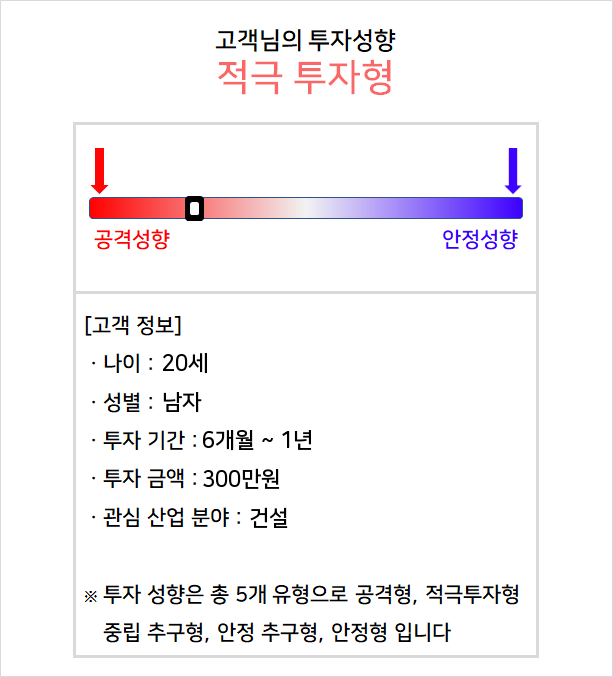

추천 주식 종목 찾는 중...
추천 ETF 찾는 중...


	 고객님의 포트폴리오입니다.


주식 종목 : 1794000.0원

DB하이텍, 46개 매입. g일 후 매도 권장. 현재가: 39000.0

채권 ETF 종목 : 298375.0원

KODEX 200미국채혼합, 6개 매입.기간 내 보유 권장. 현재가: 12425.0
TIGER 단기선진하이일드(합성 H), 5개 매입.기간 내 보유 권장. 현재가: 12025.0
TIGER 미국달러단기채권액티브, 5개 매입.기간 내 보유 권장. 현재가: 9490.0
KODEX 미국채10년선물, 5개 매입.기간 내 보유 권장. 현재가: 11570.0
TIGER 미국채10년선물, 5개 매입.기간 내 보유 권장. 현재가: 11680.0

일반 ETF 종목 : 896040.0원

KBSTAR 코스닥150선물레버리지, 9개 매입. 20일 후 매도 권장. 현재가: 15730.0
TIGER 코스닥150 레버리지, 9개 매입. 20일 후 매도 권장. 현재가: 16725.0
KODEX 코스닥150 레버리지, 9개 매입. 20일 후 매도 권장. 현재가: 15700.0
KODEX 미국S&P바이오(합성), 9개 매입. 20일 후 매도 권장. 현재가: 36730.0
ARIRANG 코스닥150, 9개 매입. 20일 후 매도 권장. 현재가: 14675.0


Button(description='결과 저장', style=ButtonStyle())

In [6]:
test1 = RED("./")
# 데이터 준비
#test1.crawling_start(10)
#test1.preprocess_start()
test1_info = test1.inter_run()                        

## 백테스팅

In [38]:
def r_sigma(data,term):
    
    if len(data) < 120: # 데이터 양이 적다면 에러처리
        return 'error'
    temp2 = data.copy()
    #temp2 = data.iloc[:-360,:]
    temp2 = temp2.iloc[:-(term+1),:] # 인덱스 초과오류방지 -> 최근 데이터는 빼기.
    
    #매수기준 1: 전날의 매수신호
    temp2 = temp2[(temp2['williams'] < -80) & (temp2['Sigma'] < -2) & (temp2['ma20'] < temp2['ma60'])].dropna() 
    if len(temp2) == 0:
        return 'error'
    
    #매수기준 2: 그날 2.5% 이상 상승한다면
    temp = data.loc[temp2.index+1,:] 
    temp = temp[temp['일수익률'] >=  2.5].dropna()  #매수기준 2: 그날 3% 이상 상승한다면
    
    buy_point = [-term]
    for i in temp.index:
        if i >= buy_point[-1] + term : # 매수시점이 매도시점과 겹치지 않게
            buy_point.append(i)
    buy_point = buy_point[1:]
    
    #수익률 계산
    res = []
    for i in buy_point: 
        profit = data.loc[i+term,'close price'] - data.loc[i,'close price']
        percentage = round(profit / data.loc[i,'close price'],2)
        res.append(percentage)
   
    if len(res) == 0: # 맞는 조건이 하나도 없다면 에러처리
        return 'error'
    return res
            

In [39]:
data_list = test1.get_datadir() 
total = []
total_cnt = 0
for i in tqdm(data_list[0]):
    data_dir = "./data/stock/" +i
    df1 = pd.read_csv(data_dir,encoding='cp949')
    ans=  r_sigma(df1,40)
    if ans != 'error':
        total.append( sum(ans) / len(ans) * 100)
        total_cnt += len(ans)
print("전체 주식종목 대비 기간수익률 : {}%".format(round(sum(total) / len(total),2)))
print("매수신호 횟수 : {}회".format(total_cnt))

100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [00:13<00:00, 25.77it/s]

전체 주식종목 대비 기간수익률 : 6.98%
매수신호 횟수 : 2602회


In [18]:
def gold_cross(data,term):
    
    if len(data) < 120: # 데이터 양이 적다면 에러처리
        return 'error'
    
    temp2 = data.copy()
    temp2 = data.iloc[:-360,:]
    temp2 = temp2.iloc[:-(term+1),:] # 인덱스 초과오류방지 -> 최근 데이터는 빼기.
    
    # 전날의 매수신호
    temp2 = temp2[(temp2['ma5'] < temp2['ma20']) & (temp2['ma5'] > temp2['ma60']) & (temp2['ma5'] > temp2['ma120'])].dropna() 
    if len(temp2) == 0:
        return 'error'
    
    # 당일의 매수신호
    temp = data.loc[temp2.index+1,:] 
    temp = temp[(temp['ma5'] >= temp['ma20']) & (temp['일수익률'] >= 2)].dropna()
    
    buy_point = [-term]
    for i in temp.index:
        if i >= buy_point[-1] + term: # 매수시점이 매도시점과 겹치지 않게
            buy_point.append(i)
    buy_point = buy_point[1:]
    
    #수익률 계산
    res = []
    for i in buy_point: 
        profit = data.loc[i+term,'close price'] - data.loc[i,'close price']
        percentage = round(profit / data.loc[i,'close price'],2)
        res.append(percentage)
   
    if len(res) == 0: # 맞는 조건이 하나도 없다면 에러처리
        return 'error'
    return res

In [19]:
data_list = test1.get_datadir() 
total = []
total_cnt = 0
for i in tqdm(data_list[0]):
    data_dir = "./data/stock/" +i
    df1 = pd.read_csv(data_dir,encoding='cp949')
    ans=  gold_cross(df1,5)
    if ans != 'error':
        total.append( sum(ans) / len(ans) * 100)
        total_cnt += len(ans)
print("전체 주식종목 대비 기간수익률 : {}%".format(round(sum(total) / len(total),2)))
print("매수신호 횟수 : {}회".format(total_cnt))

100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [00:11<00:00, 30.89it/s]

전체 주식종목 대비 기간수익률 : 0.87%
매수신호 횟수 : 1620회


In [8]:
df1 = stocker()
for i in df1 :
    if i[1] == 'g':
        print(i[0], "5일후매도")
    else:
         print(i[0], "40일후매도")

0it [00:00, ?it/s]c:\users\samsung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  
c:\users\samsung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:248: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\samsung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:254: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\samsung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:289: SettingWithCopyWa

LG생활건강 5일후매도
삼성생명 5일후매도
일양약품 40일후매도
금호타이어 5일후매도
하림지주 5일후매도
